In [ ]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
plt.style.use('ggplot')
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns
import pandas as pd
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K

latent_dim = 2

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
data = np.concatenate([x_train, x_test], axis=0)
norm_data = np.expand_dims(data, -1).astype("float32") / 255

X_train = np.expand_dims(x_train, -1).astype("float32") / 255
X_test = np.expand_dims(x_test, -1).astype("float32") / 255
y_train_onehot, y_test_onehot = to_categorical(y_train), to_categorical(y_test)

In [ ]:
norm_data.shape

(70000, 28, 28, 1)

In [ ]:
class Sampling(layers.Layer):
  def call(self, inputs):
    z_mean, z_log_var = inputs
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# VAE

## Network

In [ ]:
encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Dropout(0.8)(x)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
x = layers.Dropout(0.8)(x)
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 14, 14, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 64)   18496       dropout[0][0]                    
____________________________________________________________________________________________

In [ ]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(64, activation='relu')(latent_inputs)
x = layers.Dense(7 * 7 * 128, activation="relu")(x)
x = layers.Reshape((7, 7, 128))(x)
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, 2)]               0         
_________________________________________________________________
dense_58 (Dense)             (None, 64)                192       
_________________________________________________________________
dense_59 (Dense)             (None, 6272)              407680    
_________________________________________________________________
reshape_13 (Reshape)         (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_50 (Conv2DT (None, 14, 14, 128)       147584    
_________________________________________________________________
conv2d_transpose_51 (Conv2DT (None, 14, 14, 64)        73792     
_________________________________________________________________
conv2d_transpose_52 (Conv2DT (None, 28, 28, 32)        1846

In [ ]:
class VAE(keras.Model):
  def __init__(self, encoder, decoder, **kwargs):
    super(VAE, self).__init__(**kwargs)
    self.encoder = encoder
    self.decoder = decoder
    self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
    self.reconstruction_loss_tracker = keras.metrics.Mean(
      name="reconstruction_loss"
    )
    self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
    self.total_val_loss_tracker = keras.metrics.Mean(name="total_val_loss")
    self.reconstruction_val_loss_tracker = keras.metrics.Mean(
      name="reconstruction_val_loss"
    )
    self.kl_val_loss_tracker = keras.metrics.Mean(name="kl_val_loss")

  @property
  def metrics(self):
    return [
      self.total_loss_tracker,
      self.reconstruction_loss_tracker,
      self.kl_loss_tracker,
      self.total_val_loss_tracker,
      self.reconstruction_val_loss_tracker,
      self.kl_val_loss_tracker,
    ]

  def train_step(self, data):
    with tf.GradientTape() as tape:
      z_mean, z_log_var, z = self.encoder(data)
      reconstruction = self.decoder(z)
      reconstruction_loss = tf.reduce_mean(
        tf.reduce_sum(
          keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
        )
      )
      kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
      kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
      total_loss = reconstruction_loss + kl_loss
    grads = tape.gradient(total_loss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
    self.total_loss_tracker.update_state(total_loss)
    self.reconstruction_loss_tracker.update_state(reconstruction_loss)
    self.kl_loss_tracker.update_state(kl_loss)
    return {
      "loss": self.total_loss_tracker.result(),
      "reconstruction_loss": self.reconstruction_loss_tracker.result(),
      "kl_loss": self.kl_loss_tracker.result(),
    }
  
  def test_step(self, data):
    z_mean, z_log_var, z = self.encoder(data)
    reconstruction = self.decoder(z)
    reconstruction_loss = tf.reduce_mean(
      tf.reduce_sum(
        keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
      )
    )
    kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
    kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
    total_loss = reconstruction_loss + kl_loss
    self.total_val_loss_tracker.update_state(total_loss)
    self.reconstruction_val_loss_tracker.update_state(reconstruction_loss)
    self.kl_val_loss_tracker.update_state(kl_loss)
    return {
      "loss": self.total_val_loss_tracker.result(),
      "reconstruction_loss": self.reconstruction_val_loss_tracker.result(),
      "kl_loss": self.kl_val_loss_tracker.result(),
    }
  

  def call(self, data):
    z_mean, z_log_var, z = self.encoder(data)
    reconstruction = self.decoder(z)
    return reconstruction

In [ ]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
history = vae.fit(X_train, validation_data=(X_test, ), epochs=5, batch_size=32)

Epoch 1/5
1875/1875 [==============================] - 14s 7ms/step - loss: 141.7630 - reconstruction_loss: 135.6631 - kl_loss: 6.7894 - val_loss: 142.1160 - val_reconstruction_loss: 135.3128 - val_kl_loss: 6.8032
Epoch 2/5
1875/1875 [==============================] - 13s 7ms/step - loss: 145.0708 - reconstruction_loss: 140.9048 - kl_loss: 6.8534 - val_loss: 148.3484 - val_reconstruction_loss: 141.7399 - val_kl_loss: 6.6085
Epoch 3/5
1875/1875 [==============================] - 13s 7ms/step - loss: 142.6344 - reconstruction_loss: 135.4339 - kl_loss: 6.8123 - val_loss: 141.5879 - val_reconstruction_loss: 134.6465 - val_kl_loss: 6.9415
Epoch 4/5
1875/1875 [==============================] - 13s 7ms/step - loss: 142.1938 - reconstruction_loss: 135.8171 - kl_loss: 6.8179 - val_loss: 142.6821 - val_reconstruction_loss: 135.9836 - val_kl_loss: 6.6984
Epoch 5/5
1875/1875 [==============================] - 12s 7ms/step - loss: 143.6433 - reconstruction_loss: 140.9686 - kl_loss: 6.7561 - val_los

## Train Result

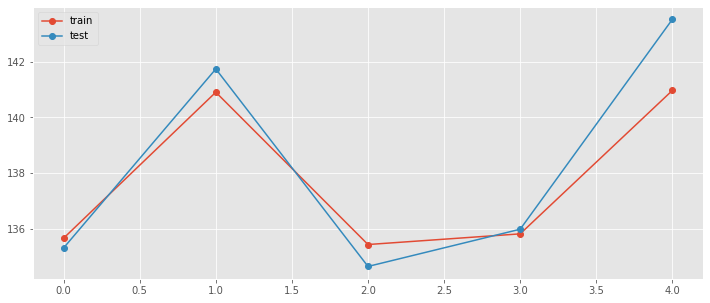

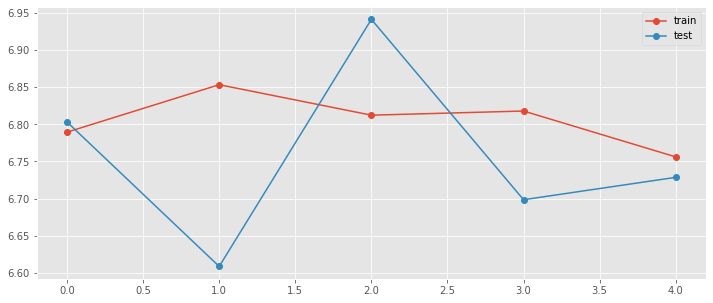

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(history.history['reconstruction_loss'], '-o')
plt.plot(history.history['val_reconstruction_loss'], '-o')
plt.legend(["train", "test"])
plt.figure(figsize=(12, 5))
plt.plot(history.history['kl_loss'], '-o')
plt.plot(history.history['val_kl_loss'], '-o')
plt.legend(["train", "test"])

## Scatter

In [ ]:
data_mean_latent, _, _ = vae.encoder.predict(norm_data)

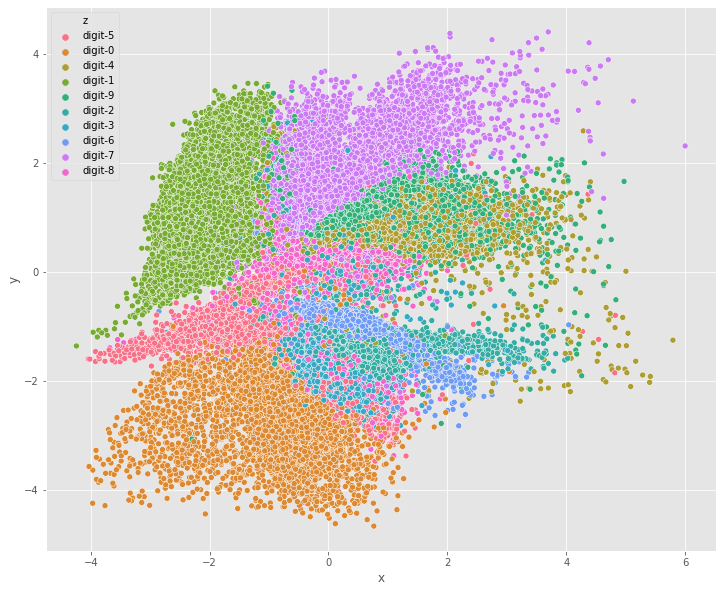

In [ ]:
df = pd.DataFrame()
df['x'] = data_mean_latent[:, 0]
df['y'] = data_mean_latent[:, 1]
df['z'] = ["digit-"+str(k) for k in np.concatenate([y_train, y_test])]

plt.figure(figsize=(12, 10))
sns.scatterplot(x='x', y='y', hue='z', data=df)
plt.show()

## Latent space to image

In [ ]:
def generate_image(vae, n=10, figsize=10):
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))

    grid_x = np.linspace(-1., 1., n)
    grid_y = np.linspace(-1., 1., n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.imshow(figure, cmap="Greys_r")
    plt.grid('off')
    plt.axis('off')
    plt.show()

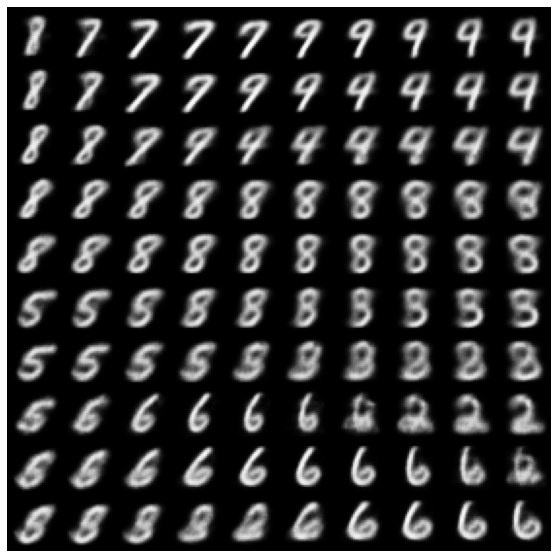

In [ ]:
generate_image(vae)

## Compare

In [ ]:
idx = np.random.choice(np.arange(0, len(X_test)), 100)
real_data = X_test[idx]
pred_data = vae.predict(real_data)

In [ ]:
pred_data[0].shape

(28, 28, 1)

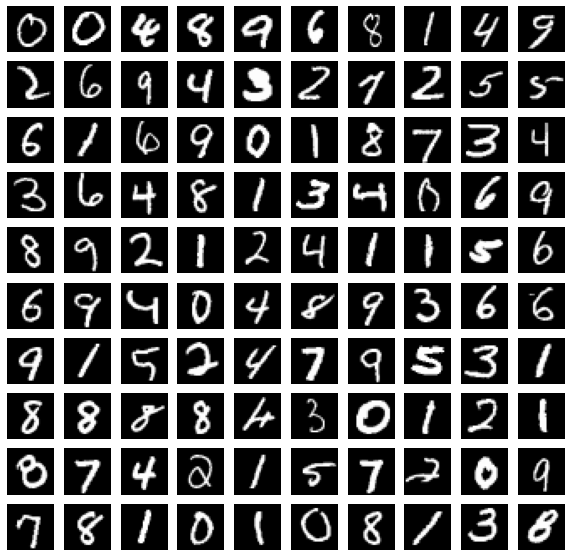

In [ ]:
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.grid('off')
for i in range(10):
  for j in range(10):
    plt.subplot(10, 10, i*10 + j + 1)
    plt.imshow(real_data[i*10+j][:, :, 0], cmap='gray')
    plt.axis('off')
    plt.grid('off')

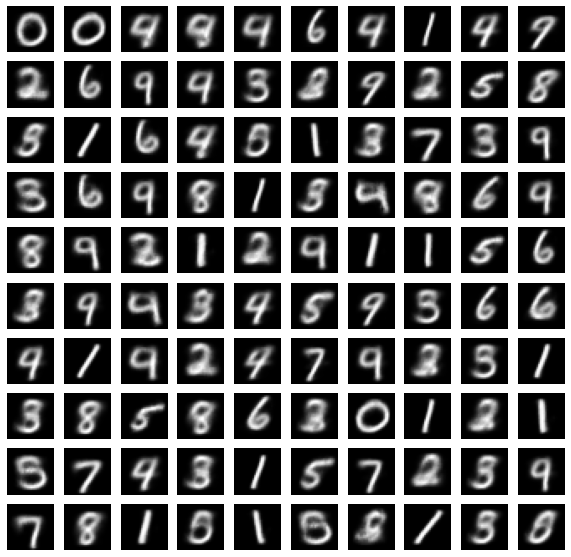

In [ ]:
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.grid('off')
for i in range(10):
  for j in range(10):
    plt.subplot(10, 10, i*10 + j + 1)
    plt.imshow(pred_data[i*10+j][:, :, 0], cmap='gray')
    plt.axis('off')
    plt.grid('off')

# CVAE

## Network

In [ ]:
input_image = keras.Input(shape=(28, 28, 1))
input_cond = keras.Input(shape=(10,))
x = layers.Dense(28 * 28)(input_cond)
x = layers.Reshape((28, 28, 1))(x)
x = layers.concatenate([input_image, x])
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Dropout(0.8)(x)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
x = layers.Dropout(0.8)(x)
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
c_encoder = keras.Model([input_image, input_cond], [z_mean, z_log_var, z, input_cond], name="encoder")
c_encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 784)          8624        input_2[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 28, 28, 1)    0           dense[0][0]                      
____________________________________________________________________________________________

In [ ]:
latent_inputs = keras.Input(shape=(latent_dim,))
cond_inputs = keras.Input(shape=(10,))
x_input = layers.Concatenate(axis=1)([latent_inputs, cond_inputs])
x = layers.Dense(7 * 7 * 128, activation="relu")(x_input)
x = layers.Reshape((7, 7, 128))(x)
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
c_decoder = keras.Model([latent_inputs, cond_inputs], decoder_outputs, name="decoder")
c_decoder.summary()

Model: "decoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 12)           0           input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 6272)         81536       concatenate_1[0][0]        

In [ ]:
class CVAE(keras.Model):
  def __init__(self, encoder, decoder, **kwargs):
    super(CVAE, self).__init__(**kwargs)
    self.encoder = encoder
    self.decoder = decoder
    self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
    self.reconstruction_loss_tracker = keras.metrics.Mean(
      name="reconstruction_loss"
    )
    self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    self.total_val_loss_tracker = keras.metrics.Mean(name="total_val_loss")
    self.reconstruction_val_loss_tracker = keras.metrics.Mean(
      name="reconstruction_val_loss"
    )
    self.kl_val_loss_tracker = keras.metrics.Mean(name="kl_val_loss")

  @property
  def metrics(self):
    return [
      self.total_loss_tracker,
      self.reconstruction_loss_tracker,
      self.kl_loss_tracker,
      self.total_val_loss_tracker,
      self.reconstruction_val_loss_tracker,
      self.kl_val_loss_tracker,
    ]

  def train_step(self, data):
    with tf.GradientTape() as tape:
      z_mean, z_log_var, z, z_cond = self.encoder([data[0][0], data[0][1]])
      reconstruction = self.decoder([z, z_cond])
      reconstruction_loss = tf.reduce_mean(
        tf.reduce_sum(
          keras.losses.binary_crossentropy(data[0][0], reconstruction), axis=(1, 2)
        )
      )
      kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
      kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
      total_loss = reconstruction_loss + kl_loss
    grads = tape.gradient(total_loss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
    self.total_loss_tracker.update_state(total_loss)
    self.reconstruction_loss_tracker.update_state(reconstruction_loss)
    self.kl_loss_tracker.update_state(kl_loss)
    return {
      "loss": self.total_loss_tracker.result(),
      "reconstruction_loss": self.reconstruction_loss_tracker.result(),
      "kl_loss": self.kl_loss_tracker.result(),
    }
  def test_step(self, data):
    z_mean, z_log_var, z, z_cond = self.encoder([data[0][0], data[0][1]])
    reconstruction = self.decoder([z, z_cond])
    reconstruction_loss = tf.reduce_mean(
      tf.reduce_sum(
        keras.losses.binary_crossentropy(data[0][0], reconstruction), axis=(1, 2)
      )
    )
    kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
    kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
    total_loss = reconstruction_loss + kl_loss
    self.total_val_loss_tracker.update_state(total_loss)
    self.reconstruction_val_loss_tracker.update_state(reconstruction_loss)
    self.kl_val_loss_tracker.update_state(kl_loss)
    return {
      "loss": self.total_val_loss_tracker.result(),
      "reconstruction_loss": self.reconstruction_val_loss_tracker.result(),
      "kl_loss": self.kl_val_loss_tracker.result(),
    }


  def call(self, data):
    # print(data[0])
    z_mean, z_log_var, z, z_cond = self.encoder(data)
    # print(z)
    return self.decoder([z, z_cond])

In [ ]:
cvae = CVAE(c_encoder, c_decoder)
cvae.compile(optimizer=keras.optimizers.Adam())
history = cvae.fit([X_train, y_train_onehot], epochs=20, batch_size=32, validation_data=[X_test, y_test_onehot])

Epoch 1/20
1875/1875 [==============================] - 45s 7ms/step - loss: 185.5554 - reconstruction_loss: 152.5895 - kl_loss: 2.8244 - val_loss: 134.5316 - val_reconstruction_loss: 129.9677 - val_kl_loss: 4.5639
Epoch 2/20
1875/1875 [==============================] - 13s 7ms/step - loss: 133.6570 - reconstruction_loss: 128.6100 - kl_loss: 4.5906 - val_loss: 132.3692 - val_reconstruction_loss: 127.5712 - val_kl_loss: 4.7981
Epoch 3/20
1875/1875 [==============================] - 13s 7ms/step - loss: 131.6817 - reconstruction_loss: 126.9486 - kl_loss: 4.6450 - val_loss: 131.4440 - val_reconstruction_loss: 126.8726 - val_kl_loss: 4.5713
Epoch 4/20
1875/1875 [==============================] - 13s 7ms/step - loss: 130.7601 - reconstruction_loss: 126.0459 - kl_loss: 4.6858 - val_loss: 131.0049 - val_reconstruction_loss: 126.3850 - val_kl_loss: 4.6199
Epoch 5/20
1875/1875 [==============================] - 13s 7ms/step - loss: 130.1288 - reconstruction_loss: 125.4932 - kl_loss: 4.7305 - va

## Train Result

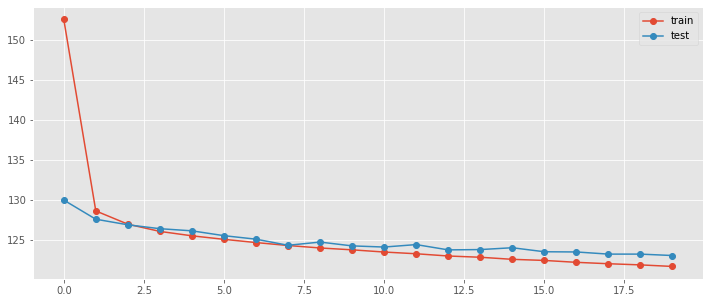

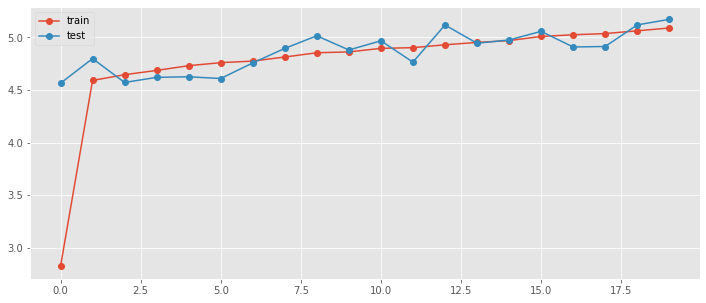

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(history.history['reconstruction_loss'], '-o')
plt.plot(history.history['val_reconstruction_loss'], '-o')
plt.legend(["train", "test"])
plt.figure(figsize=(12, 5))
plt.plot(history.history['kl_loss'], '-o')
plt.plot(history.history['val_kl_loss'], '-o')
plt.legend(["train", "test"])

## Scatter

In [ ]:
_, _,data_mean_latent, cond_latent = cvae.encoder.predict([X_train, y_train_onehot])

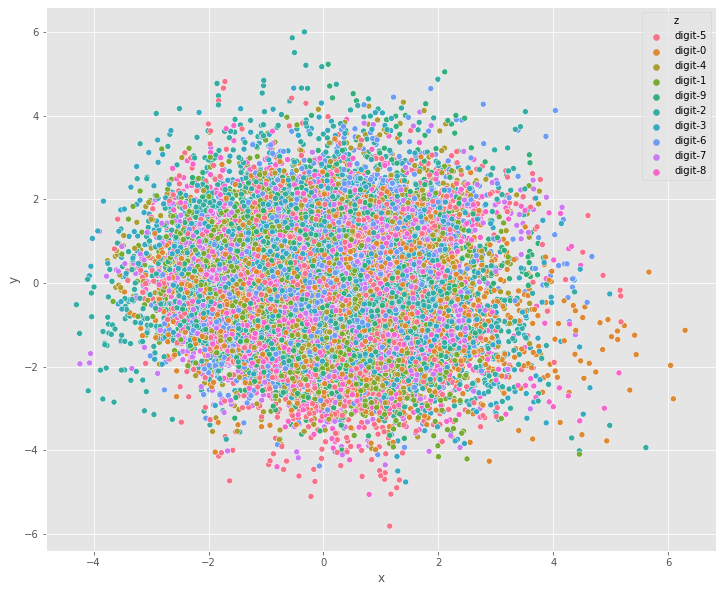

In [ ]:
df = pd.DataFrame()
df['x'] = data_mean_latent[:, 0]
df['y'] = data_mean_latent[:, 1]
df['z'] = ["digit-"+str(k) for k in y_train]

plt.figure(figsize=(12, 10))
sns.scatterplot(x='x', y='y', hue='z', data=df)
plt.show()

In [ ]:
cond_data_mean_latent

array([[-0.00446773,  0.3715899 ],
       [-0.51774305, -0.0100964 ],
       [-0.8781433 ,  0.21963382],
       ...,
       [-0.06954652,  0.32105425],
       [-0.71998644, -0.5001857 ],
       [-0.8184819 , -1.2269158 ]], dtype=float32)

## Latent space to image

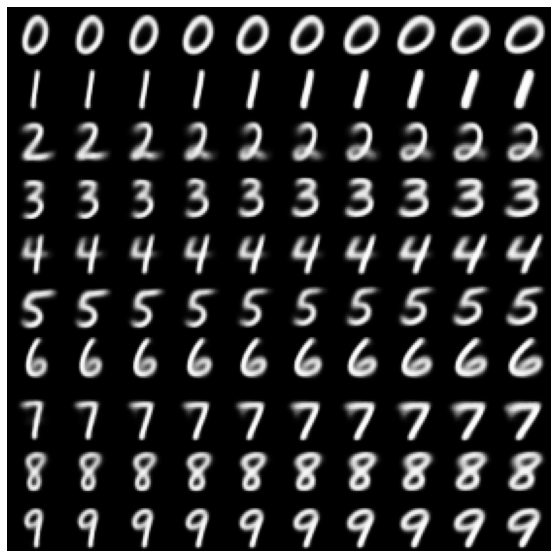

In [ ]:
def generate_image_c(vae, n=10, figsize=10):
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))

    grid_x = np.linspace(-1., 1., n)
    grid_y = np.linspace(-1., 1., n)[::-1]

    for i in range(10):
      condition_num = np.array([to_categorical(i, 10)])
      for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, 0]])
        x_decoded = c_decoder.predict([z_sample, condition_num])
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[
          i * digit_size : (i + 1) * digit_size,
          j * digit_size : (j + 1) * digit_size,
        ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.imshow(figure, cmap="Greys_r")
    plt.grid('off')
    plt.axis('off')
    plt.show()
generate_image_c(cvae)

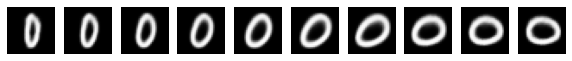

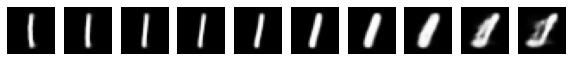

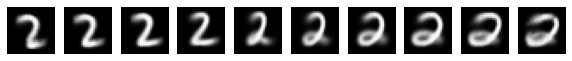

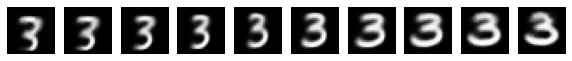

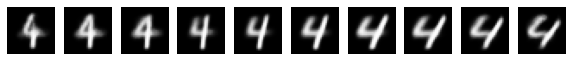

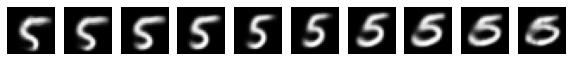

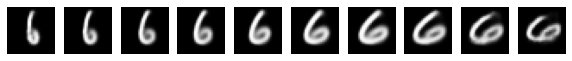

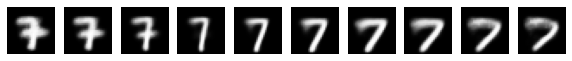

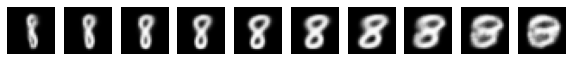

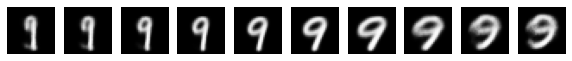

In [ ]:
digit_size = 28
for cond_num in range(10):
    condition_num = np.array([to_categorical(cond_num, 10)])
    plt.figure(figsize=(10, 1))
    grid_x = np.linspace(-3.0, 3.0, 10)
    for i in range(10):
        z_sample = np.array([[grid_x[i], 0]])
        x_decoded = c_decoder.predict([z_sample, condition_num])
        digit = x_decoded[0].reshape(digit_size, digit_size)

        plt.subplot(1, 10, i+1)
        plt.axis('off')
        plt.imshow(digit, cmap='Greys_r',)

plt.show()

## Compare

In [ ]:
idx = np.random.choice(np.arange(0, len(X_train)), 100)
real_data = X_train[idx]
real_label = y_train_onehot[idx]
latent_mean, _, _, _ = cvae.encoder([real_data, real_label])
pred_data = cvae.decoder([latent_mean, real_label])

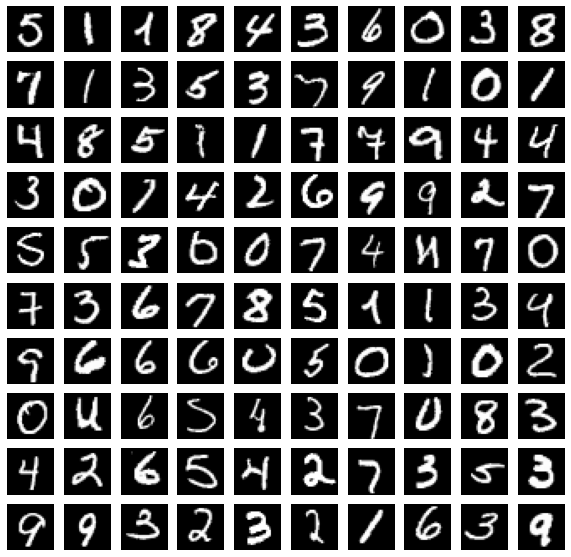

In [ ]:
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.grid('off')
for i in range(10):
  for j in range(10):
    plt.subplot(10, 10, i*10 + j + 1)
    plt.imshow(real_data[i*10+j][:, :, 0], cmap='gray')
    plt.axis('off')
    plt.grid('off')

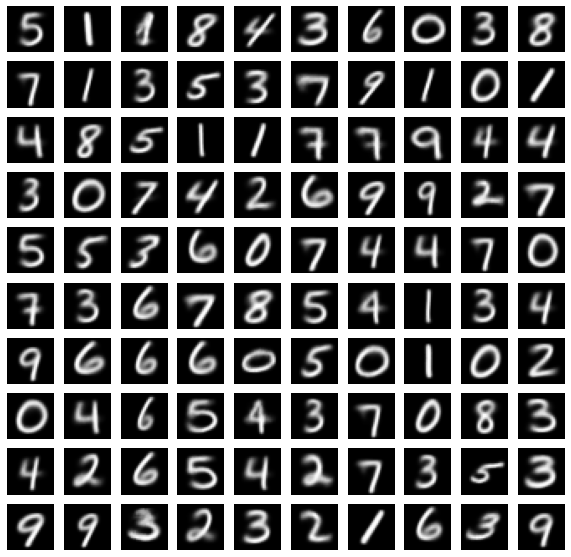

In [ ]:
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.grid('off')
for i in range(10):
  for j in range(10):
    plt.subplot(10, 10, i*10 + j + 1)
    plt.imshow(pred_data[i*10+j][:, :, 0], cmap='gray')
    plt.axis('off')
    plt.grid('off')